## Use this notebook after you've trained sufficiently your SiameseNet



#### Accept the results with a pinch of salt. We don't really know why your signature will be most similar to your doppelgänger, it's hard to interpret model's "logic". The results can also be a result of an overfit or similar texture\clothes\position of your mouth and many more...

In [1]:
# Load pre-trained model, and make predictions to get the signatures of all celebs

from tqdm import tqdm
import numpy as np
import os
from keras.models import load_model, Model
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121, preprocess_input
from triplet_loss import triplet_loss
from keras.layers import Input, GlobalAveragePooling2D
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

model = load_model('siamese.h5', custom_objects = {'triplet_loss': triplet_loss})
# embedding model
embedded_model = model.layers[3]

# Load convolution features
convfeats = np.load('conv_feats.npy')


inp = Input(convfeats.shape[1:])
infer_convfeat = Model(inp, embedded_model(inp))
preds = np.zeros((len(convfeats), K.int_shape(infer_convfeat.output)[-1]))

for k, x in tqdm(enumerate(convfeats)):
    preds[k] = infer_convfeat.predict(x[None])[0]
    
np.save('emb_celebrities', preds)

Using TensorFlow backend.
202599it [03:22, 1000.81it/s]


## Create final test model to test new image

In [15]:
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(218, 178, 3))
x = GlobalAveragePooling2D()(densenet.output)
test_model = Model(densenet.input, embedded_model(x))

## Display doppelgänger of all images that are in 'test_imgs' folder
It will display your image, with 2 most similar celebrities to you and the least similar one.

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


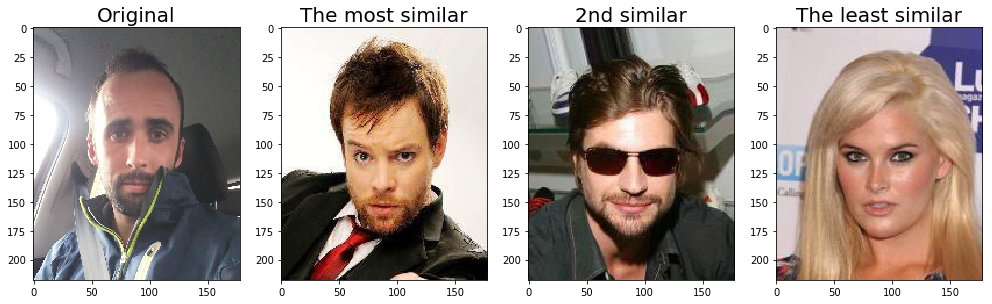

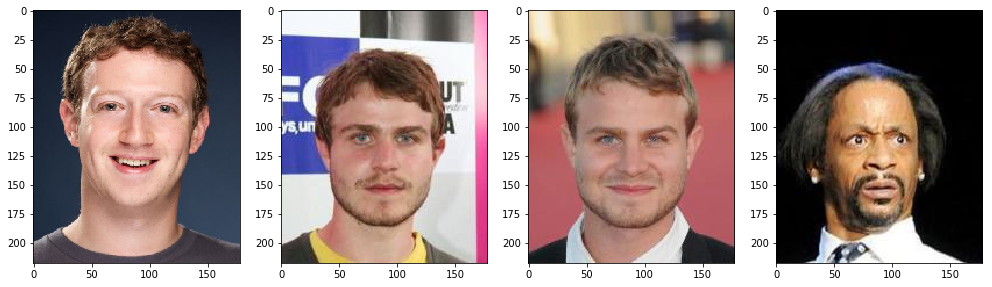

In [44]:
imgs = sorted(os.listdir('test_imgs/'))
imgs = list(set(imgs).difference(['.ipynb_checkpoints']))

for k, file in enumerate(imgs):
    img = image.load_img('test_imgs/{}'.format(file)).resize((178, 218))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = test_model.predict(x)
    res = -np.matmul(preds, pred.T)
    sorted_similar = np.argsort(res, axis=0)
    plt.figure(figsize=(17,10))
    if not(k):
        plt.subplot(1,4,4)
        plt.title('The least similar', fontsize=20)
        plt.subplot(1,4,3)
        plt.title('2nd similar', fontsize=20)
        plt.subplot(1,4,2)
        plt.title('The most similar', fontsize=20)
        plt.subplot(1,4,1)
        plt.title('Original', fontsize=20)
    plt.subplot(1,4,1)
    plt.imshow(img)
    for i, s in enumerate(sorted_similar[:2]):
        img = image.load_img(PATH + 'img_align_celeba/{}'.format(celeb_data['image'].values[s][0]))
        x = image.img_to_array(img)
        plt.subplot(1,4,i+2)
        plt.imshow(x.astype('uint8'))
    img = image.load_img(PATH + 'img_align_celeba/{}'.format(celeb_data['image'].values[sorted_similar[-1]][0]))
    x = image.img_to_array(img)
    plt.subplot(1,4,4)
    plt.imshow(x.astype('uint8'))